In [37]:
# Importar librerías

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import math
from textblob import TextBlob

# Librerías de Selenium

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time
from time import sleep

In [5]:
# Scrolls

def _count_needed_scrolls(browser, infinite_scroll, numOfPost):
    if infinite_scroll:
        lenOfPage = browser.execute_script(
            "window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return lenOfPage;"
        )
    else:
        # roughly 8 post per scroll kindaOf
        lenOfPage = int(numOfPost / 8)
    return lenOfPage


def _scroll(browser, infinite_scroll, lenOfPage):
    lastCount = -1
    match = False

    while not match:
        if infinite_scroll:
            lastCount = lenOfPage
        else:
            lastCount += 1

        # wait for the browser to load, this time can be changed slightly ~3 seconds with no difference, but 5 seems
        # to be stable enough
        time.sleep(1)

        if infinite_scroll:
            lenOfPage = browser.execute_script(
                "window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return "
                "lenOfPage;")
        else:
            browser.execute_script(
                "window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return "
                "lenOfPage;")

        if lastCount == lenOfPage:
            match = True

In [44]:
# Scrape titles

def headers(n, search_str='BTC'):
    option = Options()
    option.headless = False
    driver = webdriver.Chrome(options=option)
    
    driver.get("https://es.investing.com/search/?tab=news&q=" + search_str)
    driver.maximize_window()

    response = []
    for x in range(math.ceil(n / 133)):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)
        try:
            WebDriverWait(driver, 5).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "div[class='articleItem']"))
            )

            news = driver.find_elements(By.CSS_SELECTOR, "div[class='articleItem']")
            print("Largo de la cadena", len(news))

            for post in news:
                counter = 0
                while True:
                    try:
                        title = post.find_element(By.CSS_SELECTOR, "div>a[class='title']")
                        font = post.find_element(By.CSS_SELECTOR, "div[class='articleDetails']>span")
                        #print(font.text)
                        date = post.find_element(By.CSS_SELECTOR, "div[class='articleDetails']>time")
                        #print(date.text)
                        response.append({'date': date.text,
                                         'title': title.text,
                                         'font': font.text}),
                                         
                                         
                        break
                    except Exception as exception:
                        if counter < 1:
                            print(exception.__class__.__name__)
                            counter += 1
                            sleep(2)
                            continue
                        else:
                            break
        finally:
            continue
    driver.quit()
    return response

In [45]:
# Obteniendo las noticias

tag = "BTC"
tweets = headers(3 ,tag)

Largo de la cadena 133
Largo de la cadena 633
Largo de la cadena 2193


In [51]:
# Armar DataFrame
df = pd.DataFrame(tweets)

# Eliminar duplicados
print(df.title.duplicated().value_counts())
df_clean = df[(df.title.duplicated() == False) & (df.title != '')].reset_index().drop(['index'], axis=1)
df_clean

False    2182
True      777
Name: title, dtype: int64


,date,title,font
0,17.12.2021,Crypto Biz: Todo lo que quiero para Navidad es...,Por CoinTelegraph
1,17.12.2021,La más reciente oferta de ETF de Valkyrie tien...,Por CoinTelegraph
2,16.12.2021,Los datos muestran que los inversores minorist...,Por CoinTelegraph
3,16.12.2021,Un tribunal de Pekín deniega la compensación m...,Por CoinTelegraph
4,16.12.2021,Analistas esperan un cambio de tendencia de Bi...,Por CoinTelegraph
...,...,...,...
2176,18.08.2021,El club de fútbol PSV Eindhoven aceptará un nu...,Por CoinTelegraph
2177,19.08.2021,El segundo mayor prestamista hipotecario de EE...,Por CoinTelegraph
2178,11.08.2021,Las altcoins se disparan mientras los alcistas...,Por CoinTelegraph
2179,12.08.2021,"Alex Saunders enfrenta una demanda de USD 350,...",Por CoinTelegraph


In [52]:
# Traducir titulos
from translate import translate

translations = translate(df_clean['title'])

In [54]:
# Con lo que tardó en traducir, mejor que me guarde las traducciones

df_clean['title_en'] = translations['to']
df_clean.to_excel("bitcoin_short.xlsx")

In [72]:
# Vamos a ver los scores

scores = []

for title in df_clean.title_en:
    scores.append(TextBlob(title).sentiment.polarity)
    
df_clean['date'] = pd.to_datetime(df_clean['date'], format="%d.%m.%Y", errors='coerce')

df_clean['scores'] = scores
df_clean.to_excel("bitcoin_short.xlsx")

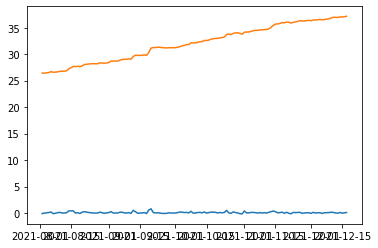

In [71]:
# Ahora a graficar

pivot_df = pd.pivot_table(df_clean, values="scores", index="date", aggfunc=np.mean)
pivot_df = pivot_df.sort_values("date")
pivot_df['cum_scores'] = np.cumsum(pivot_df.scores)
plt.plot(pivot_df[pivot_df.index > "08-1-2021"])